<a href="https://colab.research.google.com/github/helonayala/sysid/blob/main/01_batch_least_squares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch least squares

This notebook implements a system identification example. It involves:

1. Generating artificial data for a spring-mass-damper system.
2. Splitting data into training and test sets.
3. Performing system identification using the batch least squares method.
4. Evaluating the model using one-step-ahead predictions.
5. Propose an activity for implementing different funcionalities and using real-world data.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## System Definition and True Parameters

We define a continuous-time spring-mass-damper system, then discretize it.
The true parameters for the discrete model are provided.

In [ ]:
# Define continuous-time spring-mass-damper system parameters
m = 0.1  # mass
b = 1.0  # damping
k_spring = 10.0  # spring constant (using k_spring to avoid clash with loop variable k)

# Create continuous-time transfer function G(s) = 1 / (ms^2 + bs + k)
G_continuous = signal.TransferFunction([1], [m, b, k_spring])

# Sampling time
Ts = 0.01

# Discretize the model (Zero-Order Hold method)
# Gd_tuple = (num_discrete, den_discrete, dt)
# num_discrete is a 2D array for MIMO systems, so we take [0] for SISO
Gd_tuple = signal.cont2discrete((G_continuous.num, G_continuous.den), Ts, method='zoh')
num_d_calculated = Gd_tuple[0][0]
den_d_calculated = Gd_tuple[1]
Gd_discrete = signal.dlti(num_d_calculated, den_d_calculated, dt=Ts)

print("Calculated Continuous Transfer Function G(s):")
print(G_continuous)
print(f"\nCalculated Discrete Transfer Function Gd(z) with Ts = {Ts}:")
print(Gd_discrete)
print(f"Numerator coefficients: {num_d_calculated}")
print(f"Denominator coefficients: {den_d_calculated}")

# True vector of parameters (as provided in the original script)
# This corresponds to y(k) = -th[0]*y(k-1) - th[1]*y(k-2) + th[2]*u(k-1) + th[3]*u(k-2)
# So, th[0] is a1, th[1] is a2, th[2] is b1 (for u(k-1)), th[3] is b2 (for u(k-2))
th_true = np.array([den_d_calculated[1], den_d_calculated[2], num_d_calculated[1], num_d_calculated[2]])
print("\nTrue parameter vector 'th_true' (used for simulation):")
print(th_true)


Calculated Continuous Transfer Function G(s):
TransferFunctionContinuous(
array([10.]),
array([  1.,  10., 100.]),
dt: None
)

Calculated Discrete Transfer Function Gd(z) with Ts = 0.01:
TransferFunctionDiscrete(
array([0.00048334, 0.00046749]),
array([ 1.        , -1.89532909,  0.90483742]),
dt: 0.01
)
Numerator coefficients: [0.         0.00048334 0.00046749]
Denominator coefficients: [ 1.         -1.89532909  0.90483742]

True parameter vector 'th_true' (used for simulation):
[-1.89532909e+00  9.04837418e-01  4.83341528e-04  4.67491667e-04]


/usr/local/lib/python3.11/dist-packages/scipy/signal/_ltisys.py:599: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  self.num, self.den = normalize(*system)


## Simulation Parameters

In [ ]:
N = 1000  # simulation steps
t = np.arange(N) * Ts # time vector (0 to (N-1)*Ts)

## Generate Training Data

A relay feedback system is used to generate exciting input for training.

In [ ]:
uamp = 10.0
yr = 1.0

# Initial conditions for y and u
u_train = np.zeros(N)
y_train = np.zeros(N)

# Loop from k=2 because y(k) depends on y(k-1), y(k-2), u(k-1), u(k-2)
for k_idx in range(2, N):
    if y_train[k_idx-1] >= yr:
        u_train[k_idx] = -uamp
    elif y_train[k_idx-1] <= -yr:
        u_train[k_idx] = uamp
    else:
        u_train[k_idx] = u_train[k_idx-1]

    # System equation: y(k) = -th_true[0]*y(k-1) - th_true[1]*y(k-2) + th_true[2]*u(k-1) + th_true[3]*u(k-2)
    y_train[k_idx] = -th_true[0] * y_train[k_idx-1] \
                             -th_true[1] * y_train[k_idx-2] \
                             +th_true[2] * u_train[k_idx-1] \
                             +th_true[3] * u_train[k_idx-2]



## Plot Training Data

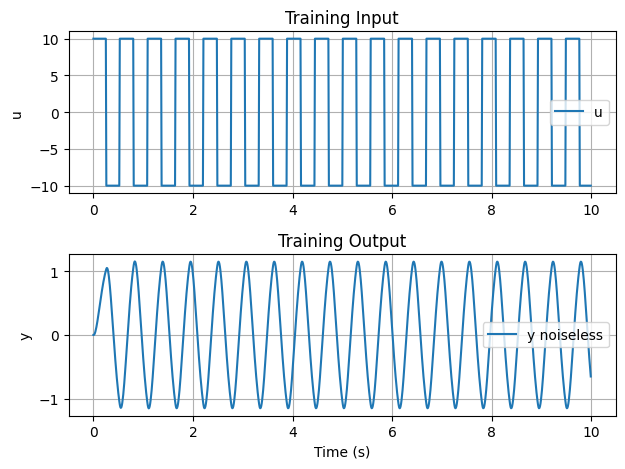

In [29]:
plt.subplot(2, 1, 1)
plt.plot(t, u_train)
plt.title('Training Input')
plt.ylabel('u')
plt.legend(['u'])
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, y_train, label='y noiseless')
plt.title('Training Output')
plt.ylabel('y')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Generate Test Data

A sum of sinusoids is used as input for the test set.

In [ ]:
u_test = uamp / 4 * np.sin(2 * np.pi * (np.arange(N)) * Ts) + \
                uamp / 4 * np.sin(np.pi / 2 * (np.arange(N)) * Ts) + \
                uamp / 4 * np.sin(np.pi * (np.arange(N)) * Ts) + \
                uamp / 4 * np.sin(np.pi / 4 * (np.arange(N)) * Ts)

y_test = np.zeros(N)

# Loop from k=2 (Python index)
for k_idx in range(2, N):
    y_test[k_idx] = -th_true[0] * y_test[k_idx-1] \
                            -th_true[1] * y_test[k_idx-2] \
                            +th_true[2] * u_test[k_idx-1] \
                            +th_true[3] * u_test[k_idx-2]



## Plot Test Data

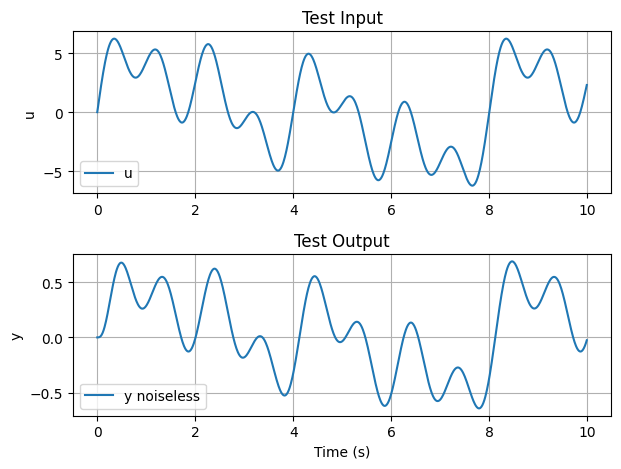

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(t, u_test)
plt.title('Test Input')
plt.ylabel('u')
plt.legend(['u'])
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, y_test, label='y noiseless')
plt.title('Test Output')
plt.ylabel('y')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Identification

We construct the regression matrix $\Phi$ and estimate the parameters $\hat{\theta}$ using batch least squares.

The model is

$y(k) = -\theta_1 y(k-1) - \theta_2 y(k-2) + \theta_3 u(k-1) + \theta_4 u(k-2)$

So we use

$\Phi = [-y(k-1), -y(k-2), u(k-1), u(k-2)]$

where each line of $\Phi$ is composed of a regression vector for a given time instant $k$.

Then an estimate of the $\theta$ is obtained using batch least squares.

In [ ]:
# Construct regression matrix Phi for training data
# Phi rows: [-YTRA[k-1], -YTRA[k-2], UTRA[k-1], UTRA[k-2]] for YTRA[k]

y_k_minus_1_TRA = -y_train[1:N-1]
y_k_minus_2_TRA = -y_train[0:N-2]
u_k_minus_1_TRA =  u_train[1:N-1]
u_k_minus_2_TRA =  u_train[0:N-2]

Phi_TRA = np.column_stack((y_k_minus_1_TRA, y_k_minus_2_TRA, u_k_minus_1_TRA, u_k_minus_2_TRA))
y_target_TRA = y_train[2:N] # Targets for training, corresponds to y(k) from k=2 to N-1

# Construct regression matrix Phi_TEST for test data
y_k_minus_1_TEST = -y_test[1:N-1]
y_k_minus_2_TEST = -y_test[0:N-2]
u_k_minus_1_TEST =  u_test[1:N-1]
u_k_minus_2_TEST =  u_test[0:N-2]

Phi_TEST = np.column_stack((y_k_minus_1_TEST, y_k_minus_2_TEST, u_k_minus_1_TEST, u_k_minus_2_TEST))
y_target_TEST = y_test[2:N] # Targets for test, corresponds to y(k) from k=2 to N-1

# Estimate parameters: Batch Least Squares
th_hat, residuals, rank, singular_values = np.linalg.lstsq(Phi_TRA, y_target_TRA, rcond=None)

print("True parameters (th_true):\n", th_true)
print("\nEstimated parameters (th_hat):\n", th_hat)

True parameters (th_true):
 [-1.89532909e+00  9.04837418e-01  4.83341528e-04  4.67491667e-04]

Estimated parameters (th_hat):
 [-1.89532909e+00  9.04837418e-01  4.83341528e-04  4.67491667e-04]


## Predictions

In order to perform OSA predictions, simply multiply the regression matrix with the estimated $\theta$.

In [ ]:
# One-step-ahead prediction for training data
yhat_TRA_OSA = Phi_TRA @ th_hat

# One-step-ahead prediction for test data
yhat_TEST_OSA = Phi_TEST @ th_hat


## Plot Predictions

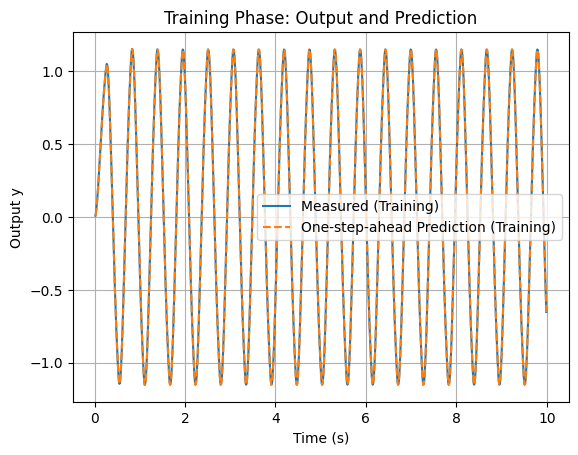

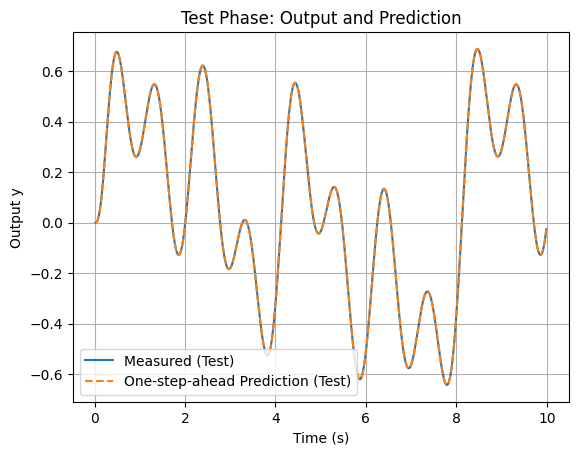

In [ ]:
# Time vector for plotting predictions
t_pred = t[2:N]

plt.plot(t_pred, y_target_TRA, label='Measured (Training)')
plt.plot(t_pred, yhat_TRA_OSA, label='One-step-ahead Prediction (Training)', linestyle='--')
plt.title('Training Phase: Output and Prediction')
plt.xlabel('Time (s)')
plt.ylabel('Output y')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(t_pred, y_target_TEST, label='Measured (Test)')
plt.plot(t_pred, yhat_TEST_OSA, label='One-step-ahead Prediction (Test)', linestyle='--')
plt.title('Test Phase: Output and Prediction')
plt.xlabel('Time (s)')
plt.ylabel('Output y')
plt.legend()
plt.grid(True)
plt.show()

## Key Learnings and Next Steps

* **Successful Parameter Recovery:** We demonstrated that the system's unknown parameters can be accurately identified using noiseless data, assuming the correct system equation is known.
* **Idealized Scenario:** This example represents an ideal case. Real-world data is rarely noiseless, and the exact system dynamics may not be perfectly known.
* **Building for Reality:** The next steps involve incorporating features to handle noisy data and explore scenarios where the system equation is not perfectly defined, making this approach applicable to real-world problems.

## Activity

This activity builds upon the batch least squares system identification example. You will enhance the existing code by creating reusable functions and applying the methodology to real-world data.

1.  **Implement a Regression Matrix Function:**
    *   Create a Python function that takes the input time series data (`u`), the output time series data (`y`), and the model orders ($n_a$ for the autoregressive part and $n_b$ for the exogenous part) as arguments.
    *   This function should construct and return two arguments: the regression matrix $\Phi$ and the output vector $Y$ (which represents the target outputs for the model).
    *   The function should handle the initial conditions appropriately, considering the maximum delay ($max(n_a, n_b)$).
    *   For each time step $k$ from $max(n_a, n_b)$ up to the end of the data, create a row in the regression matrix $\Phi$. This row should contain the values `[-y(k-1), -y(k-2), ..., -y(k-na), u(k-1), u(k-2), ..., u(k-nb)]`. The corresponding value in the output vector $Y$ should be `y(k)`.
    *   Ensure the dimensions of $\Phi$ and $Y$ are consistent with the number of data points used after accounting for initial conditions.
    *   Improve the "Identification" section of the notebook by calling this new function with the training data to obtain `Phi_TRA` and `y_target_TRA`, and with the test data to obtain `Phi_TEST` and `y_target_TEST`.
    *   *Tip:* Consider a function like `matReg` in https://github.com/helonayala/narx_narendra/blob/main/narendra.ipynb.

2.  **Implement a Free-Run Simulation Function:**

    *   Create a Python function that performs a free-run simulation of the identified model. This function should take the estimated parameter vector ($\hat{\theta}$), the input signal for simulation, and the initial conditions for the simulation as arguments.

    *   The free-run simulation means that future output values are calculated based on the previously simulated output values, not the measured data.

    *   The initial conditions for the simulation (the first $max(n_a, n_b)$ output values) should be taken from the measured data used for identification.

    *   Within the function, for each time step $k$ after the initial conditions, construct the regression vector using the *simulated* past outputs and the current or past *input* values from the provided input signal. Use the function you created in step 1 to build these individual regression vectors.

    *   Calculate the predicted output for time step $k$ by multiplying the regression vector at time $k$ by the estimated parameter vector $\hat{\theta}$.

    *   *Tip:* Consider a function like `freeRun` in https://github.com/helonayala/narx_narendra/blob/main/narendra.ipynb.

3.  **Apply to Real-World Data (Coupled Drives Data):**
    *   Substitute the synthetic data generated in the notebook with the provided coupled drives data.
    *   **Part a: Linearity Assessment:**
        *   Use the data from the random steps experiment as your training data.
        *   Use the data from the increasing/decreasing sequence of steps experiment as your test data.
        *   Plot the predictions in free-run for training and test data against measured data. Based on the plot, assess whether a single linear model adequately represents the system behavior across different operating points (steps).

    *   **Part b: Segmented Linear Models:**
        *   Focus solely on the increasing/decreasing sequence of steps data for this part.
        *   Try to obtain a separate linear model for each distinct operating envelope within this dataset (e.g., one model for each constant step level). You will need to segment the data accordingly.
        *   Evaluate how well each individual linear model performs in predicting the output within its specific operating segment. You can plot the measured output for each segment against its corresponding free-run simulation.

